# Data Exploration

### Imports

In [10]:
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Load image metadata

In [11]:
base_dir = r'data'  # change this to your RAWDATA FOlder
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
records = []

for cls in classes:
    cls_dir = os.path.join(base_dir, cls)
    for fname in os.listdir(cls_dir):
        fpath = os.path.join(cls_dir, fname)
        try:
            with Image.open(fpath) as img:
                width, height = img.size
                fmt = img.format
                mode = img.mode
                 

            records.append({
                'path': fpath,
                'class': cls,
                'width': width,
                'height': height,
                'format': fmt,
                'mode': mode,
                
            })
        except Exception as e:
            records.append({
                'path': fpath,
                'class': cls,
                'width': None,
                'height': None,
                'format': None,
                'mode': None,
                'error': str(e)
            })

df = pd.DataFrame(records)

df.to_csv('image_metadata.csv', index=False)   

### Image Format Distribution

format
BMP    2520
PNG     480
Name: count, dtype: int64


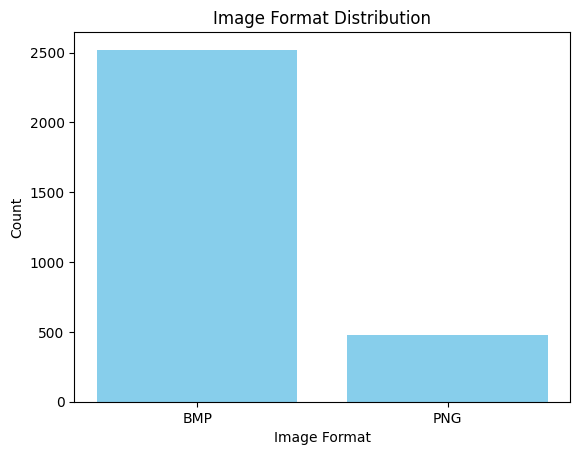

In [12]:
df['format'].value_counts()
format_counts = df['format'].value_counts()
print(format_counts)
plt.bar(format_counts.index, format_counts.values, color='skyblue')
plt.title("Image Format Distribution")
plt.xlabel("Image Format")
plt.ylabel("Count")
plt.show()


### Class Distribution

Abnormal Sperm: 1005 images 
Non Sperm: 974 images 
Normal Sperm: 1021 images


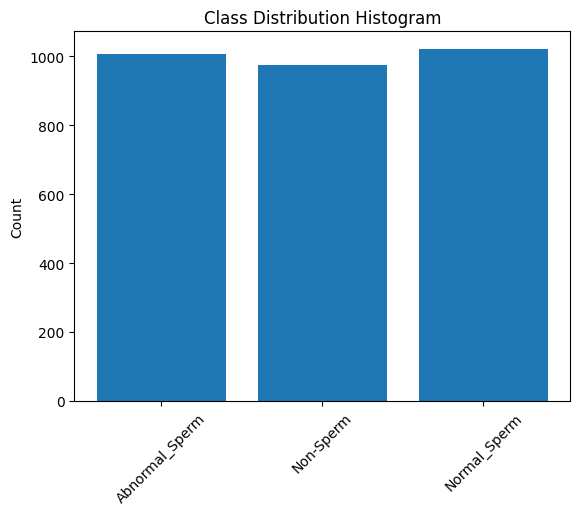

In [15]:
classes = os.listdir(base_dir)
counts = [len(os.listdir(os.path.join(base_dir, c))) for c in classes]
print (f"Abnormal Sperm: {counts[0]} images \nNon Sperm: {counts[1]} images \nNormal Sperm: {counts[2]} images")
plt.bar(classes, counts)
plt.title("Class Distribution Histogram")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

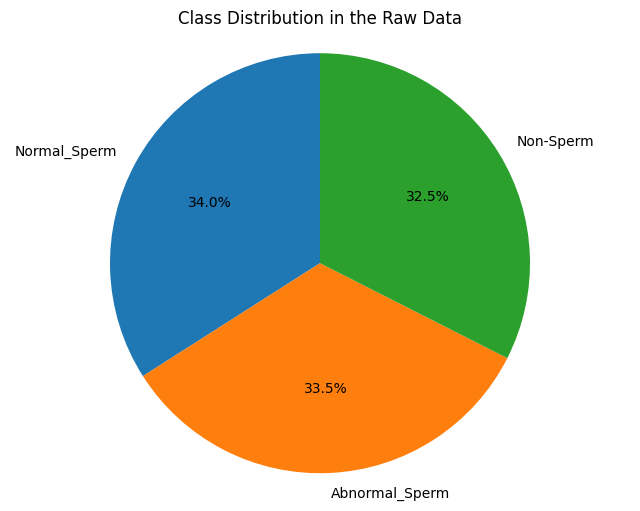

In [32]:
counts = df['class'].value_counts().rename_axis('class').reset_index(name='counts')

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(counts['counts'], labels=counts['class'] , autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution in the Raw Data')
plt.axis('equal') # otherwise pie chart could look smaller and like an oval  
plt.show()

### Image Width / Height Distribution

Image Width:
  Minimum Width: 122 px
  Maximum Width: 259 px
  Average Width: 171.16 px

Image Height:
  Minimum Height: 80 px
  Maximum Height: 264 px
  Average Height: 168.17 px


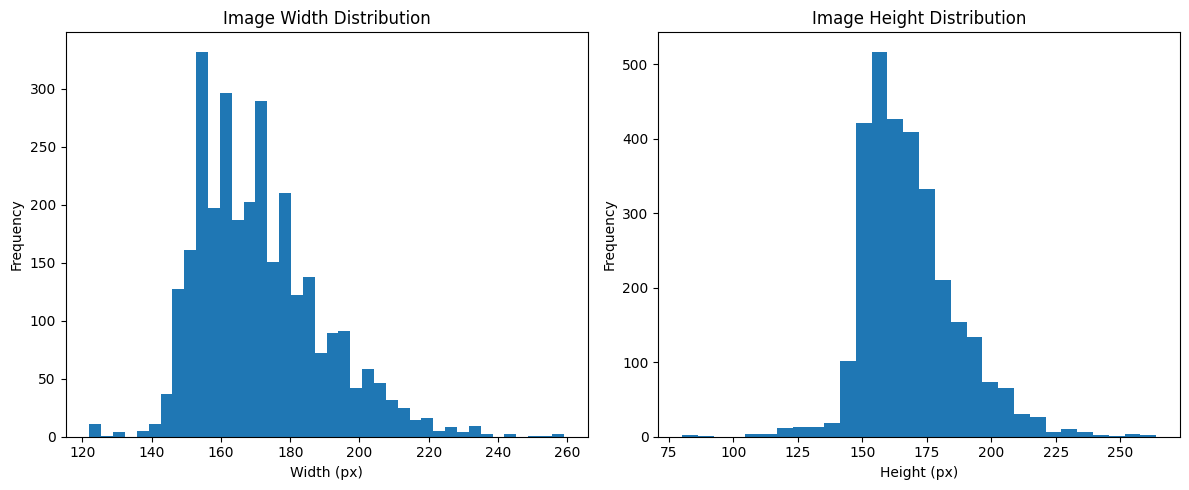

In [8]:
# Hey dont forget that we are working with the 'df' DataFrame, which contains the metadata, you can use the image_metadata.csv file as well 

widths = df['width']
heights = df['height']

print("Image Width:")
print(f"  Minimum Width: {widths.min()} px")
print(f"  Maximum Width: {widths.max()} px")
print(f"  Average Width: {widths.mean():.2f} px\n")

print("Image Height:")
print(f"  Minimum Height: {heights.min()} px")
print(f"  Maximum Height: {heights.max()} px")
print(f"  Average Height: {heights.mean():.2f} px")

# Create 1 row with 2 columns 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Left plot: Width distribution
axes[0].hist(df['width'].dropna(), bins=40) 
# Understand the bins parameter: It start with the minimum value and goes to the maximum value in this case
# around 120 for widt and 70 for height, then it splits these range into 40 equal parts (bins)
# I select 40 bins to have a more detailed view of the distribution, if increasing it might look too noisy 

axes[0].set_title('Image Width Distribution')
axes[0].set_xlabel('Width (px)')
axes[0].set_ylabel('Frequency')

# Right plot: Height distribution
axes[1].hist(df['height'].dropna(), bins=30)
axes[1].set_title('Image Height Distribution')
axes[1].set_xlabel('Height (px)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()   # Adjust spacing so titles/labels don’t overlap
plt.show()


In [10]:
# To check for unreadable images run this code
unreadable_images = df[df['width'].isna()]
print(unreadable_images[['path', 'class', 'width', 'height', 'format', 'mode']])


Empty DataFrame
Columns: [path, class, width, height, format, mode]
Index: []


In [11]:
# What does this histogram tell us about the distribution of image sizes? This is actually very important to understand!!! 
# We can present this distrubtion as a reason why we are resizing the images later


# From my opinion, there is not a clear standard size in our dataset, most of them are in:
# - Width: between 150 and 180 pixels
# - Height: between 140 and 175 pixels
# Again, there is  large inconsistency in the image sizes, could affect our model? Yes
# Before the model, it might affect our preprocessing steps cuz some steps might depend on the image size which could generate distortions on the values




<Figure size 640x480 with 0 Axes>

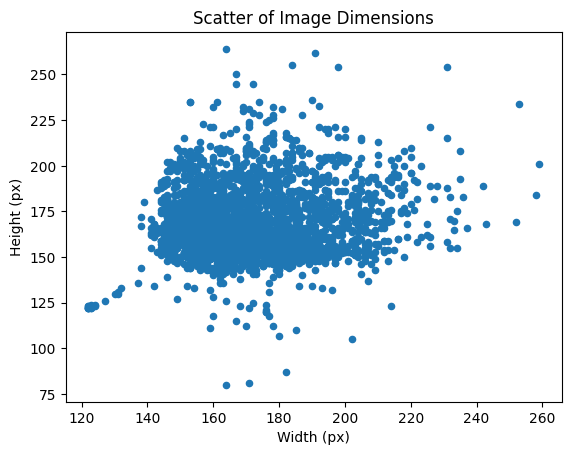

In [12]:
# 4. Scatter plot of width vs. height
# This scatter just re-affirm what i meant before, we can see that most of the images are among a range of size but outside of this range we can find other images as well
# Would we consider those as outliers? Yes! I think so, since those values have completely different sizes, some of them small some of them larger
# What do we do with them?  Resizing!
# Other alternative would be deleting them but not what i'd do.


plt.figure()
df.dropna(subset=['width', 'height']).plot.scatter(x='width', y='height')
plt.title('Scatter of Image Dimensions')
plt.xlabel('Width (px)')
plt.ylabel('Height (px)')
plt.show()

In [18]:
# Drop rows with missing width or height
valid_df = df.copy()

# Calculate image area
valid_df['area'] = valid_df['width'] * valid_df['height']

# Find smallest image
smallest = valid_df.loc[valid_df['area'].idxmin()]

# Find largest image
largest = valid_df.loc[valid_df['area'].idxmax()]

# Calculate average area
avg_area = valid_df['area'].mean()

# Find image whose area is closest to the average area
closest_avg = valid_df.iloc[(valid_df['area'] - avg_area).abs().idxmin()]

# Print results
print("Smallest Image:")
print(f"  Width: {smallest['width']} px, Height: {smallest['height']} px, Area: {smallest['area']} px²\n")

print("Largest Image:")
print(f"  Width: {largest['width']} px, Height: {largest['height']} px, Area: {largest['area']} px²\n")

print("Average Image (Closest to Mean Area):")
print(f"  Width: {closest_avg['width']} px, Height: {closest_avg['height']} px, Area: {closest_avg['area']} px²")


Smallest Image:
  Width: 164 px, Height: 80 px, Area: 13120 px²

Largest Image:
  Width: 253 px, Height: 234 px, Area: 59202 px²

Average Image (Closest to Mean Area):
  Width: 161 px, Height: 179 px, Area: 28819 px²


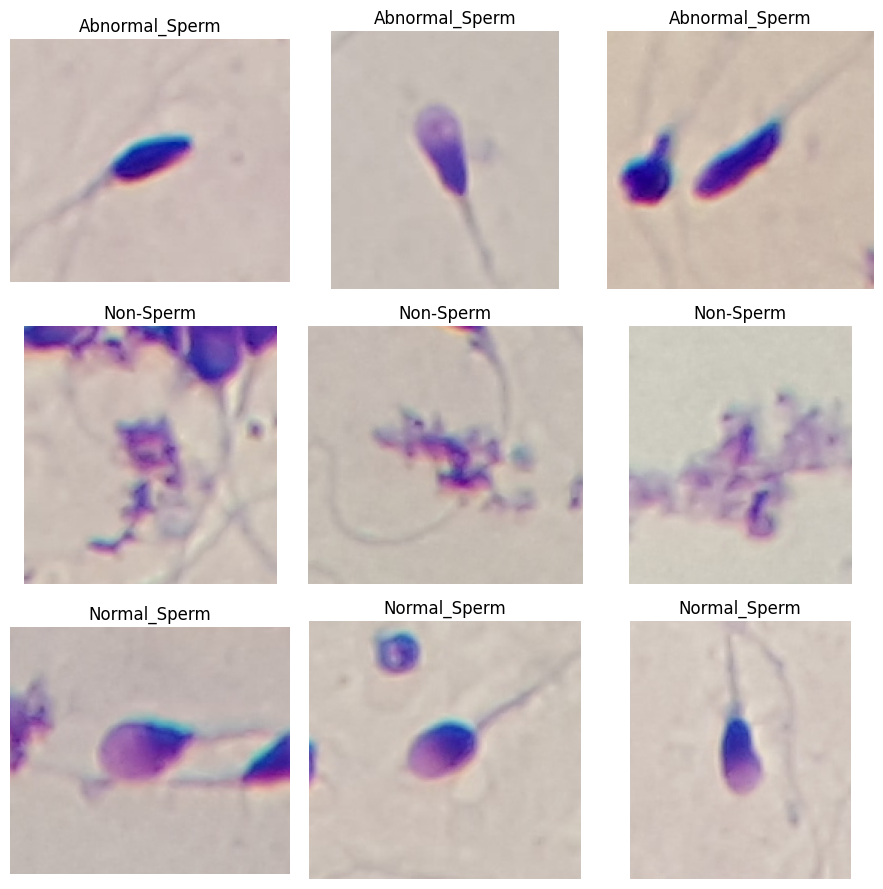

In [13]:
fig, axes = plt.subplots(len(classes), 3, figsize=(9, 3 * len(classes)))
for i, cls in enumerate(classes):
    samples = df[df['class'] == cls].sample(min(3, len(df[df['class'] == cls])))
    for j, (_, row) in enumerate(samples.iterrows()):
        img = Image.open(row['path'])
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(cls)
plt.tight_layout()
plt.show()

### Resizing Images

height, width, channel
Before Resize: (164, 193, 3)
After Resize: (180, 160, 3)


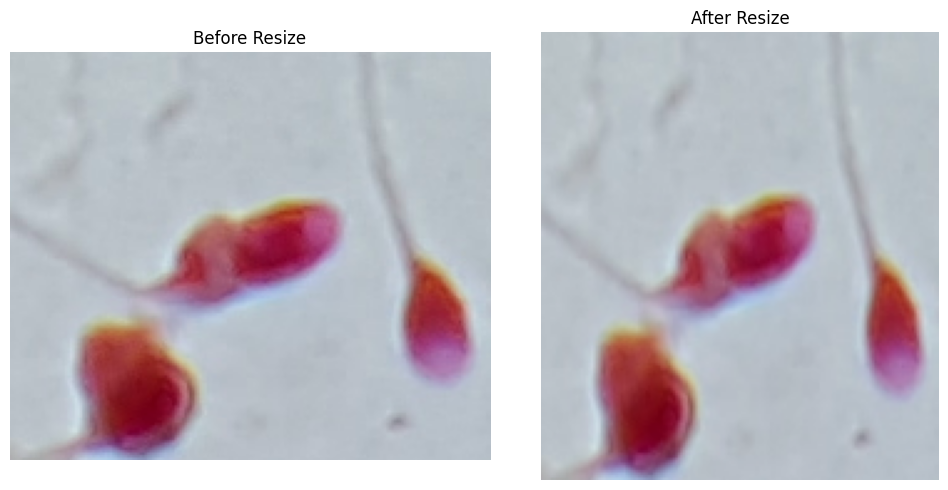

In [23]:
image_paths = []
labels = []
for classes in os.listdir(base_dir):
    for img_file in os.listdir(f"data/{classes}/"):
        image_paths.append(f"data/{classes}/{img_file}")
        labels.append(classes)

df = pd.DataFrame({"image_path": image_paths, "label": labels})

# Load the images
def load(path):
    img= cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
    
# Resize the images
#width, height
def resize(img, img_size=(160,180)):
    img = cv2.resize(img, img_size)
    return img

df["raw_image"] = df["image_path"].apply(load)
df["resized_image"] = df["raw_image"].apply(resize)


# Print shapes
print("height, width, channel")
print("Before Resize:", df["raw_image"][1].shape)
print("After Resize:", df["resized_image"][1].shape)

# Converts BGR (OpenCV) to RGB (Matplotlib)
def cv2_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plott the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2_to_rgb(df["raw_image"][1]))
plt.title("Before Resize")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2_to_rgb(df["resized_image"][1]))
plt.title("After Resize")
plt.axis('off')

plt.tight_layout()
plt.show()